In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
log = "benchmark.log"

# Initialize variables
records = []
current_benchmark = ""
current_N = 0
current_R = 0
current_result = 0.0

In [3]:
def parse_log(log):
    # Process each line
    for line in open(log, 'r'):
        line = line.strip()
        if 'Bechmarking' in line:
            current_benchmark = line.split()[1].strip(':')
        elif 'N =' in line:
            parts = line.split(',')
            current_N = int(parts[0].split('=')[1].strip())
            current_R = int(parts[1].split('=')[1].strip(':'))
        elif 'Result:' in line:
            current_result = float(line.split(':')[1].strip())
        elif 'N:' in line:
            t_val = float(re.search(r'<T>: (.*?) sec', line).group(1))
            b_val = float(re.search(r'B: (.*?) GB/sec', line).group(1))
            f_val = float(re.search(r'F: (.*?) FLOP/sec', line).group(1))
            record = {
                'Benchmark': current_benchmark,
                'N': current_N,
                'R': current_R,
                'Result': current_result,
                'Time (sec)': t_val,
                'Bandwidth (GB/sec)': b_val,
                'FLOP/sec': f_val
            }
            records.append(record)

    # Create DataFrame
    df = pd.DataFrame(records)

    # Deduplicate by N and R
    df = df.drop_duplicates(subset=['N', 'R', 'Benchmark']).reset_index(drop=True)

    return df

In [4]:
df = parse_log(log)
df

,Benchmark,N,R,Result,Time (sec),Bandwidth (GB/sec),FLOP/sec
0,dp1,1000000,1000,1000000.0,0.000960,8.360,2.089978e+09
1,dp1,300000000,20,16777216.0,0.288828,8.310,2.077395e+09
2,dp2,1000000,1000,1000000.0,0.000272,29.916,7.478984e+09
3,dp2,300000000,20,67108864.0,0.133833,17.940,4.484934e+09
4,dp3,1000000,1000,1000000.0,0.000047,190.878,4.771940e+10
5,dp3,300000000,20,300000000.0,0.042761,56.335,1.408367e+10
6,dp4,1000000,1000,300000000.0,0.198523,0.040,1.008948e+07
7,dp4,300000000,20,300000000.0,58.925354,0.041,1.018265e+07
8,dp5,1000000,1000,300000000.0,0.000155,53.736,1.343388e+10
9,dp5,300000000,20,300000000.0,0.105927,22.677,5.669267e+09


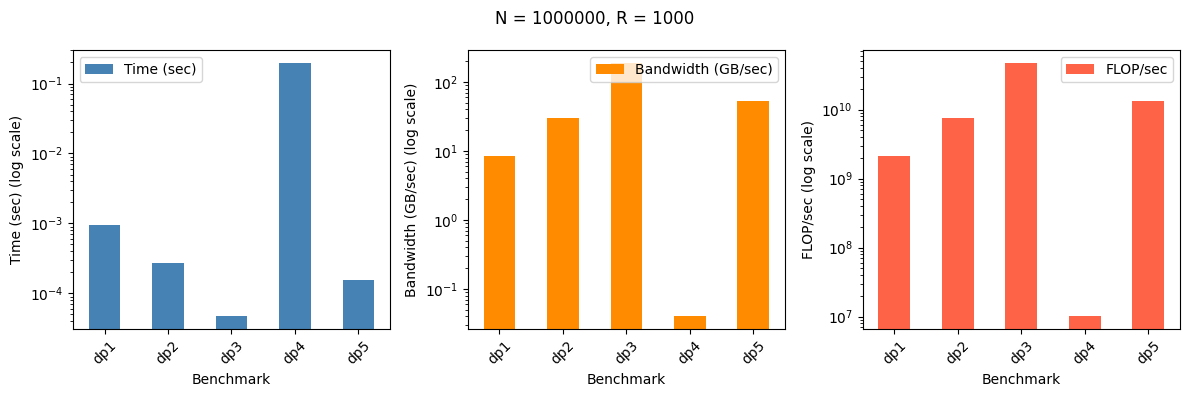

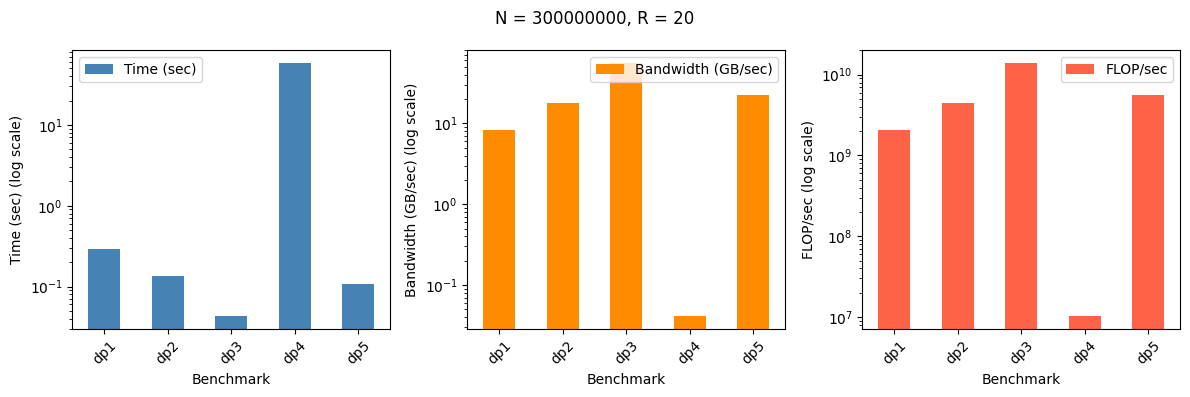

In [5]:
# visualize for benchmark
cols = ['Time (sec)', 'Bandwidth (GB/sec)', 'FLOP/sec']
colors = ["steelblue", "darkorange", "tomato"]

def vis(N, R, df):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, ax in enumerate(axs.flatten()):
        sub_df = df.query(f'N == {N} and R == {R}')
        sub_df.plot(x='Benchmark', y=cols[i], kind='bar', ax=ax, color=colors[i])
        ax.set_yscale('log')
        ax.set_ylabel(cols[i] + ' (log scale)')
        ax.set_xticklabels(sub_df['Benchmark'], rotation=45)
    plt.suptitle(f"N = {N}, R = {R}")
    plt.tight_layout()
    plt.show()

vis(1000000, 1000, df)
vis(300000000, 20, df)

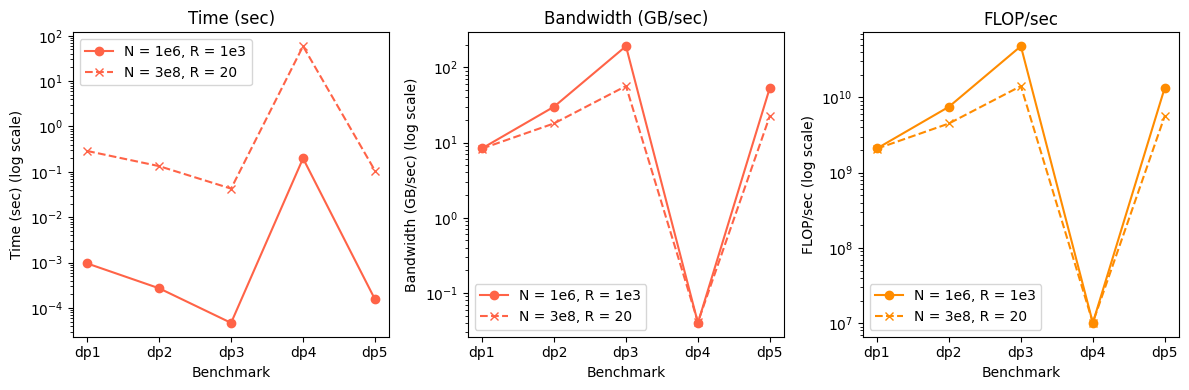

In [17]:
def panel(df):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, ax in enumerate(axs.flatten()):
        sub_df1 = df.query(f'N == 1000000 and R == 1000')
        sub_df2 = df.query(f'N == 300000000 and R == 20')
        sub_df1.plot(x='Benchmark', y=cols[i], kind='line', ax=ax, color=colors[i], marker='o')
        sub_df2.plot(x='Benchmark', y=cols[i], kind='line', ax=ax, color=colors[i], linestyle='--', marker='x')
        ax.set_title(cols[i])
        ax.set_yscale('log')
        ax.set_ylabel(cols[i] + ' (log scale)')
        ax.legend(['N = 1e6, R = 1e3', 'N = 3e8, R = 20'])
    plt.tight_layout()
    return plt

panel(df).savefig("img/metric-panel.png")

### Roofline Plot

In [7]:
GB2B = 2 ** 30
BANDWIDTH = 30 * GB2B # B/s
MAX_FLOPS = 200 * GB2B # FLOPS
balance_point = MAX_FLOPS / BANDWIDTH  # FLOP/Byte
ai_range = np.logspace(np.log10(0.01), np.log10(100), 100)
roofline = np.minimum(MAX_FLOPS, BANDWIDTH * ai_range)
balance_point

6.666666666666667

In [8]:
df['arithmetic_intensity'] = 2 * df['N'] / (2 * df['N'] * 4)  # FLOP/Byte

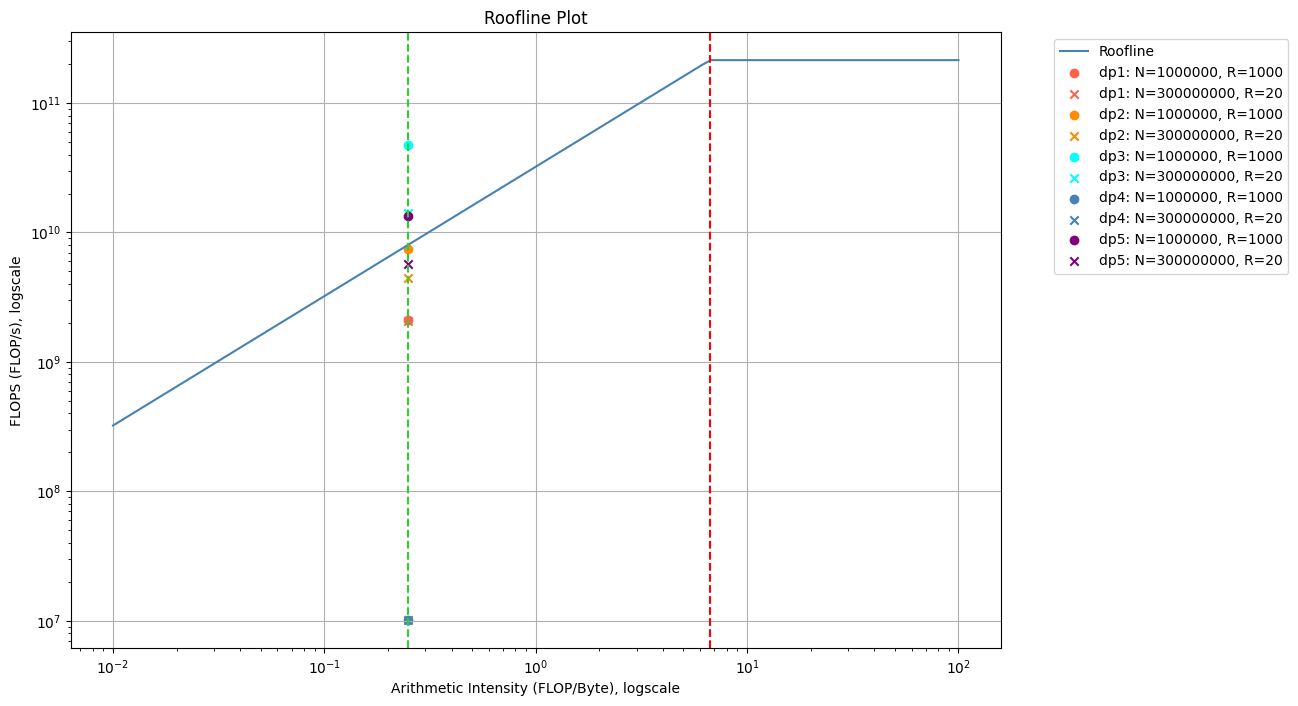

In [18]:
color_dict = {
    "dp1": "tomato",
    "dp2": "darkorange",
    "dp3": "aqua",
    "dp4": "steelblue",
    "dp5": "purple",
}
marker_dict = {
    1000000: "o",
    300000000: "x",
}
colors = df['Benchmark'].map(lambda x: color_dict[x])
markers = df['N'].map(lambda x: marker_dict[x])
x, y = df['arithmetic_intensity'], df['FLOP/sec']
labels = df.apply(lambda x: f"{x['Benchmark']}: N={x['N']}, R={x['R']}", axis=1)

def vis() -> plt.figure:
    plt.figure(figsize=(12, 8))
    plt.loglog(ai_range, roofline, label='Roofline', color='steelblue')
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color=colors[i], marker=markers[i], label=labels[i])

    plt.xlabel('Arithmetic Intensity (FLOP/Byte), logscale')
    plt.ylabel('FLOPS (FLOP/s), logscale')
    plt.axvline(balance_point, color='red', linestyle='--')
    plt.axvline(df['arithmetic_intensity'].max(), color='limegreen', linestyle='--')
    plt.title('Roofline Plot')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    return plt

vis().savefig("img/roofline.png", bbox_inches='tight')